In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import keras
import cv2
import h5py

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


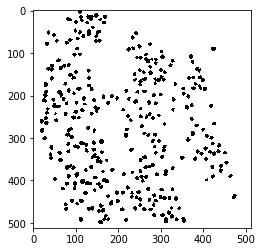

255 1


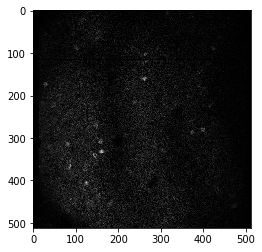

224 0


In [2]:
import cv2
frame_no = 499
cap = cv2.VideoCapture('Databinary/substack500_7fps_00.label.tif') #video_name is the video being called
cap.set(1,frame_no); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
plt.imshow(frame)
plt.show()
print(frame.max(), frame.min())
cap = cv2.VideoCapture('Databinary/substack500_7fps_00.avi') #video_name is the video being called
cap.set(1,frame_no); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
plt.imshow(frame)
plt.show()
print(frame.max(), frame.min())

The input images thus need to be normalised because values are not within the range of 0 and 1. This will hopefully help the network to optimise better

DEFINE MODEL AND TRAINING PROCEDURE

In [3]:
from keras.models import Model
from keras.layers.convolutional import Conv3D, Conv2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, TimeDistributed
import keras.backend as K
import tensorflow as tf
from keras.optimizers import *

from keras.layers import (ConvLSTM2D, BatchNormalization, Convolution3D, Convolution2D,Conv2D,
                          TimeDistributed, MaxPooling2D, UpSampling2D, Input, merge, Cropping2D, concatenate)


K.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0})))

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)



def load_model(batch_size,true_frag_len):
    input_shape = (None, 256, 400, 1)
    input = Input(batch_shape= [batch_size, true_frag_len, 256,400, 1])
    
    x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(input)
    x = TimeDistributed(MaxPooling2D((2, 2), (2, 2)))(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(filters=14, kernel_size=(3, 3),
                       input_shape=input_shape,
                       padding='same', 
                       return_sequences=True,
                       stateful = True)(x)
    x = BatchNormalization()(x)
    x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(x)
    
    upsl_1 = TimeDistributed(UpSampling2D((2, 2)))(x)
    output = TimeDistributed(Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid'), name='output')(upsl_1)
    # output = Conv3D(filters=1, kernel_size=(3, 3, 3),
    #                    activation='sigmoid',
    #                    padding='same', data_format='channels_last')(x)


    model_stateful_batch = Model(inputs = [input], output=[output])
    #model_stateful_batch.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model_stateful_batch.compile(loss='binary_crossentropy', optimizer= 'adadelta')

    model_stateful_batch.summary()
    return model_stateful_batch

In [14]:
import time
def train_model(model, no_samples, no_frags, generator,valid_generator,epochs, frag_len, model_validator):
    print("Training for " + str(epochs) + " epochs")
    #training_losses = []
    epoch_times = []
    for epoch in range(epochs):
        epoch_time = time.time()
        print("Number of training reps per epoch " + str(no_samples))
        for reps in range(reps_for_samples):
            if reps%(no_frags) == 0:
               #print ('Time to reset states')
                model.reset_states()
            train_loss = 0
            X,Y = next(generator.generate())
            train_loss += model.train_on_batch(X, Y)
            #print ('# Fragement ', reps, '  loss ', train_loss)
            #training_losses.append(train_loss)
           # print(training_losses)
            #if reps%no_frags == 0:
            if reps%50 == 0:
                print ('# Iteration', reps, '  loss ', train_loss)
                #print(train_loss)
        print ('# Epoch', epoch + 1, '  loss ', train_loss)
        model.reset_states()
        print("Done training")
        print("Traing loss " + str(train_loss))
        #print("Validating")
        model_validator.validate(model,no_frags, frag_len, valid_generator)
        duration = time.time()- epoch_time
        epoch_times.append(duration)
        
    return model, epoch_times

In [133]:
from skimage import measure
from regional import many
from neurofinder import centers, shapes
from skimage.filters import threshold_yen
from skimage.morphology import closing, square

class Validate_and_Metrics(object):
    

    def __init__(self):
        self.precisions = []
        self.recalls = []
        self.f1scores = []
        
    def validate(self, model, no_frags, frag_len, valid_generator):
        self.model = model
        self.no_frags = no_frags
        self.frag_len = frag_len
        ypred = self.batch_prediction(valid_generator)
        # this frag len is not defined so we need a way to get it in here
        # the true one needs to be normalised to be compared properly
        ytrue = self.ytrue_for_validation()
        #we need the last result of all the fragments
        ypred_ind = ypred[no_frags-1][0][frag_len-1].reshape(256,400)
        print(ypred_ind.shape)
        thresh = threshold_isodata(ypred_ind)
        print(thresh)
        ypred_thresh = (closing(ypred_ind > thresh, square(3)))*255

        #print(ytrue.max(), ytrue.min())
        #print(ypred.max(), ypred.min())
        #print(ytrue.reshape(256,400).shape)
        #print(ypred.reshape(256,400).shape)
        the_metric = self.nf_mask_metrics(ytrue.reshape(256,400),ypred_thresh.reshape(256,400))
        #print(the_metric)
        
    def ytrue_for_validation(self):
        vect = cv2.VideoCapture("Databinary/substack500_7fps_07.label.tif")
        vect.set(1,1)
        ret,lab_frame = vect.read()
        lab_frame = cv2.resize(lab_frame,(400,256))
        lab_frame = cv2.cvtColor(lab_frame, cv2.COLOR_BGR2GRAY)
        return lab_frame
    
    def batch_prediction(self, generator ):
    # this just tests out one sample. I think it is necessary to reset states on prediction too
        stateful_preds = []
        self.model.reset_states()
        gen = generator.generate()
        for fragment in range(self.no_frags):
            X,Y = next(gen)
            stateful_batch = self.model.predict_on_batch(X)
            stateful_preds.append(stateful_batch)
        return stateful_preds
    
    
    def _mask_to_regional(self, m):
        """Convert a 2D numpy mask to a regional many object so it can be measured
        using the neurofinder library."""
        mlbl = measure.label(m,background=255 )
        coords = []
        for lbl in range(1, np.max(mlbl) + 1):
            yy, xx = np.where(mlbl == lbl)
            coords.append([[y, x] for y, x in zip(yy, xx)])
       
        return many(coords)
    
    def nf_mask_metrics(self, m, mp):
        """Computes precision, recall, inclusion, exclusion, and combined (F1) score for the given mask (m) and predicted mask (mp). Note that this does assumes single 2D masks and does not aaccount for overlapping neurons.

        # Arguments
            m: ground-truth (height x width) binary numpy mask.
            mp: predicted (height x width) binary numpy mask.

        # Returns
            p,r,i,e,f1: precision, recall, inclusion, exclusion, and F1 scores.

        """
        # Return all zeros if the predicted mask is empty.
        if np.sum(mp.round()) == 0:
            return 0., 0., 0., 0., 0.
        
        print(type(m))
        print(type(mp))
        print(m.shape)
        print(mp.shape)
        # Convert masks to regional format and compute their metrics.
        mreg = self._mask_to_regional(m)
        print(type(mreg))
        print(mreg)
        mpreg = self._mask_to_regional(mp)
        print(type(mpreg))
        print(mpreg)

        r, p = centers(mreg, mpreg,threshold=7 )
        i, e = shapes(mreg, mpreg)
        f1 = 2. * (r * p) / (r + p)
        self.precisions.append(p)
        self.recalls.append(r)
        self.f1scores.append(f1)
        #print(self.precisions, self.recalls, self.f1scores)
        return (p, r, i, e, f1)
    
    def get_metrics(self):
        return {
            'precisions': self.precisions,
            'recalls':self.recalls,
            'f1scores':self.f1scores
        }
    

In [108]:
validator = Validate_and_Metrics()

<function matplotlib.pyplot.show(*args, **kw)>

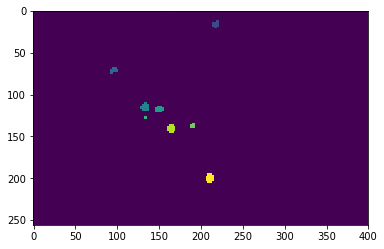

In [100]:
ey = measure.label(bw, background=255)
ey.shape
plt.imshow(ey)
plt.show

In [93]:
reg= validator._mask_to_regional(bw)

In [94]:
reg.center

[array([  0.5, 163.5]),
 array([ 16.5 , 217.75]),
 array([71.3, 96.1]),
 array([115., 133.]),
 array([117.67647059, 150.26470588]),
 array([127.5, 133.5]),
 array([136.75, 190.75]),
 array([140.5, 164.5]),
 array([199.62, 210.66])]

(256, 400)
(256, 400) (256, 400)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(256, 400)
(256, 400)
<class 'regional.regional.many'>
regions
count: 5199
<class 'regional.regional.many'>
regions
count: 9


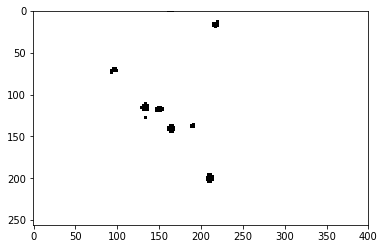

Max value: 255


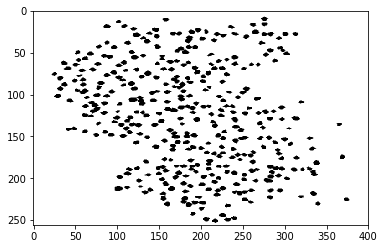

Max value: 1.0


In [114]:
from skimage.filters import threshold_yen, threshold_isodata, threshold_otsu
from skimage.morphology import closing, square

ypred_test = predicted[4]
thresh = threshold_isodata(ypred_test)
bw = (closing(ypred_test > thresh, square(3)))*255
#threshpredicted = (ypred_test>thresh)*255
print(bw.shape)

ytrue_test = validator.ytrue_for_validation()
print(bw.shape, ytrue_test.shape)
validator.nf_mask_metrics(ytrue_test.reshape(256,400),bw.reshape(256,400))

plt.imshow(bw, cmap = 'gray')
plt.show()
print('Max value: ' + str(bw.max()))

plt.imshow(ytrue_test, cmap = 'gray')
plt.show()
print('Max value: ' + str(y[0][0].max()))

In [106]:
validator.get_metrics()

{'f1scores': [0.002304147465437788],
 'precisions': [0.6666666666666666],
 'recalls': [0.001154068090017311]}

## STOCHASTIC
## STATEFUL batch_shape = [1, frag_len, x, y, 1]
    1 sample at a time
    update made after no_fragments batches
    y = [1, 1, x, y, 1]

DEFINE DATA FEEDER

There are two ways to sample the data as illustrated below. Check it out. The only difference is how indexes are defined for data range of each fragment and then the no of resulting fragments.

no of fragments and length of fragments changes with the step size so the real length becomes (frag_len+1)/steps and number of fragments is (data_len-frag_len + 1)/steps

In [26]:
example = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21, 22]
data_len = len(example)
frag_len = 11
steps = 2
no_frags = int((data_len-frag_len + 1)/steps)
print(no_frags)

for current_count in range(no_frags):
    #ranger = list(range(current_count,current_count+ frag_len))
    indx = np.arange(current_count*steps,current_count*steps+ frag_len, steps)
    print(np.array(example)[indx.astype(int)])
(np.array(example)[indx.astype(int)]).shape

6
[ 1  3  5  7  9 11]
[ 3  5  7  9 11 13]
[ 5  7  9 11 13 15]
[ 7  9 11 13 15 17]
[ 9 11 13 15 17 19]
[11 13 15 17 19 21]


(6,)

no of fragments does not change with the step size but, the actual length of the fragment is changed by the step size. so the real length becomes (frag_len+1)/steps 

In [27]:
example = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21, 22]
data_len = len(example)
frag_len = 11
steps = 2
no_frags = int(data_len-frag_len + 1)
print(no_frags)

for current_count in range(no_frags):
    #ranger = list(range(current_count,current_count+ frag_len))
    indx = np.arange(current_count,current_count+ frag_len, steps)
    print(np.array(example)[indx.astype(int)])
(np.array(example)[indx.astype(int)])

12
[ 1  3  5  7  9 11]
[ 2  4  6  8 10 12]
[ 3  5  7  9 11 13]
[ 4  6  8 10 12 14]
[ 5  7  9 11 13 15]
[ 6  8 10 12 14 16]
[ 7  9 11 13 15 17]
[ 8 10 12 14 16 18]
[ 9 11 13 15 17 19]
[10 12 14 16 18 20]
[11 13 15 17 19 21]
[12 14 16 18 20 22]


array([12, 14, 16, 18, 20, 22])

Quick check to make sure the data is loaded correctly by the data generator. Also a quick check to make sure the images returned are nomalised (value range between 0 and 1). 

NB. Make sure current sample number of next output block is the same as the label vect that is read by cv2 when drawing otherwise images wont match and you might think it is not working

In [116]:
class Batch_size_1_Generator(object):

    def __init__(self, frag_len, steps = 1, valid = False):
        self.frag_len = frag_len
        #print(frag_len)
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        self.current_count = 0
        self.data = None
        # dimensions expected by the network
        self.dims = (400,256)
        self.steps = steps
        self.valid = valid
    
        #self.dup_rows()
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set

    def dup_rows(self, a, indx, num_dups=1):
        return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)
    
    def _resizeNnormalize(self, data, dimso):
        """
        data : the image to be resized 
        dimso : the dimensions to be resized to (tuple)
        """
        data = cv2.resize(data, dimso)
        img = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
        nomalized = img/255
        return nomalized
    
    
    def generate(self):
        # this generator returns no_frag fragments for each sample before moving to the next sample
        while True:
            if self.valid == True:
                self.current_idx = '10'
                #if self.current_count == 0:
                    #print('Validating')
            elif self.current_count == 0:
                self.current_idx = '0' + str(np.random.randint(10))
                print("Current sample is : " + self.current_idx)
            video = cv2.VideoCapture('Databinary/substack500_7fps_' + self.current_idx + '.avi')

            data_len = 50
            # find out number of fragments for data
            no_frags = int((data_len-self.frag_len + 1)/self.steps)
            #no_frags = int(data_len/frag_len)
            
            #print("No frags inside " + str(no_frags))
            self.current_count += 1
            #print('current sample number: ' + str(self.current_idx)+', Fragment ' + str(self.current_count)+ ' of ' + str(no_frags))
            
            if self.current_count == no_frags:
                #print(self.current_count)
                self.current_count = 0
            data_range = (self.current_count,self.current_count+ self.frag_len)
            #print(data_range)
            
            x = []

            # data_range is the range of frames to be fetched for each fragment
            indxs = np.arange(self.current_count*steps,self.current_count*steps+ frag_len, steps)
            #indxs = np.arange(self.current_count*self.frag_len,(self.current_count+1)* self.frag_len, steps)

            #for indexer in range(data_range[0],data_range[1]):
            for indexer in indxs:

                video.set(1,indexer) # Where frame_no is the frame you want
                ret, frame = video.read() # Read the frame
                x.append(self._resizeNnormalize(frame, self.dims))
         
            #print('No frags ' + str(no_frags))
            
             
            labels = cv2.VideoCapture('Databinary/substack500_7fps_' + str(self.current_idx) + '.label.tif')
            labels.set(1,1)
            ret,lab_frame = labels.read()
            y = []
            for indx in range(len(x)):
            #for indx in range(int((self.frag_len+1)/self.steps)-1):
                y.append(self._resizeNnormalize(lab_frame, self.dims))
                
            y = np.expand_dims(y, axis=-1)
            x = np.expand_dims(x, axis=-1)
            y = np.expand_dims(y, axis=0)
            x = np.expand_dims(x, axis=0)
           
            #yield x,y
            yield x,y
            

In [117]:
# Set params batch size 1
data_len = 50
steps = 2
frag_len = 10
true_frag_len = int((frag_len+1)/steps)
no_frags = int((data_len-frag_len + 1)/steps)
print(no_frags)
batch_size = 1
no_videos = 10
reps_for_samples = no_videos*no_frags
print(reps_for_samples)
epochs = 1

20
200


Check to see if Generator is loading data correctly

In [118]:
print('True fragment length ' +str(true_frag_len))
gener_obj = Batch_size_1_Generator(frag_len, steps)
gener = gener_obj.generate()
X,y = next(gener)
X.shape, y.shape

True fragment length 5
Current sample is : 00


((1, 5, 256, 400, 1), (1, 5, 256, 400, 1))

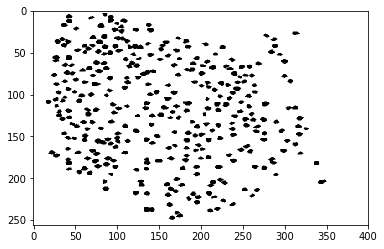

Max value: 255


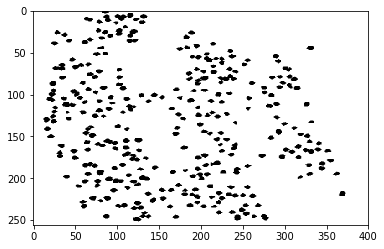

Max value: 1.0


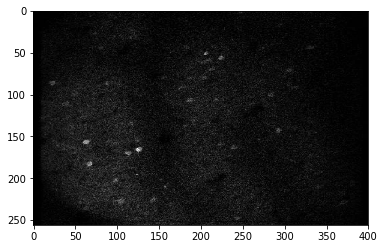

Max value: 0.7098039215686275


In [11]:
vect = cv2.VideoCapture("Databinary/substack500_7fps_03.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(400,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()
print('Max value: ' + str(lab_frame.max()))

plt.imshow(y[0][0].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(y[0][0].max()))

plt.imshow(X[0][0].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(X[0][0].max()))

TRAIN

In [122]:
model_stateful_batch1 = load_model(batch_size,true_frag_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (1, 5, 256, 400, 1)       0         
_________________________________________________________________
time_distributed_9 (TimeDist (1, 5, 256, 400, 2)       20        
_________________________________________________________________
time_distributed_10 (TimeDis (1, 5, 128, 200, 2)       0         
_________________________________________________________________
batch_normalization_5 (Batch (1, 5, 128, 200, 2)       8         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (1, 5, 128, 200, 14)      8120      
_________________________________________________________________
batch_normalization_6 (Batch (1, 5, 128, 200, 14)      56        
_________________________________________________________________
time_distributed_11 (TimeDis (1, 5, 128, 200, 2)       254       
__________

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/ipykernel_launcher.py:52: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [ ]:
gener = Batch_size_1_Generator(frag_len, steps)
valid_generator = Batch_size_1_Generator(frag_len, steps, valid = True)
validator = Validate_and_Metrics()
model_stateful_batch1_trained, epoch_execution_time = train_model(model_stateful_batch1, reps_for_samples, no_frags, gener,valid_generator,epochs, true_frag_len, validator)

Training for 1 epochs
Number of training reps per epoch 200
Current sample is : 02
# Iteration 0   loss  0.5130411982536316
Current sample is : 00
Current sample is : 04
# Iteration 50   loss  0.5136257410049438
Current sample is : 02
Current sample is : 09
Current sample is : 04
# Iteration 100   loss  0.5072457790374756
Current sample is : 09
Current sample is : 01
# Iteration 150   loss  0.4805161654949188
Current sample is : 02
Current sample is : 09


In [25]:
stocahstic_metrics = validator.get_metrics()
stocahstic_metrics

{'f1scores': [0.5431002976035086],
 'precisions': [1.0],
 'recalls': [0.37277809633027525]}

In [24]:
stochastic_execution_time = epoch_execution_time
stochastic_execution_time

In [467]:
save_model(model_stateful_batch1_trained, 'stochastic_5e_frag_50_step_2_len500_vid')

PREDICT ON TRAINED MODEL

In [27]:
# Predict using just a single sample loaded from file
gener_1 = Batch_size_1_Generator(frag_len, steps)
# this just tests out one sample. I think it is necessary to reset states on prediction too
stateful_preds = validator.batch_prediction(gener_1)

Current sample is : 06


In [28]:
len(stateful_preds), stateful_preds[0][0].shape

(20, (5, 256, 400, 1))

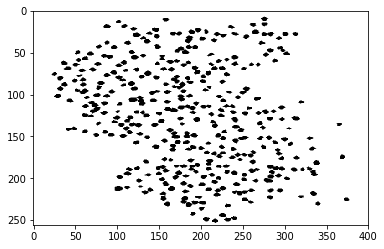

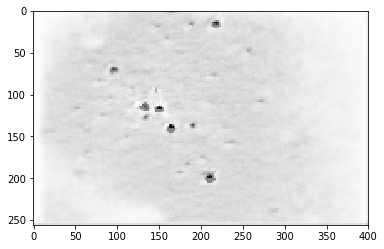

In [29]:
predicted = stateful_preds[15][0].reshape(true_frag_len,256,400)

vect = cv2.VideoCapture("Databinary/substack500_7fps_07.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(400,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()

#predicted result
plt.imshow(predicted[2], cmap = 'gray')
plt.show()

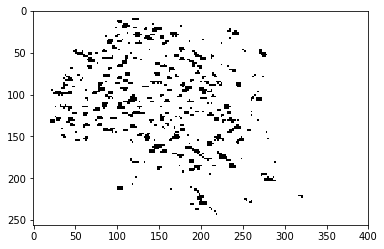

In [557]:
#fig, ax = try_all_threshold(predicted[1], figsize=(10, 8), verbose=False)
thresh = threshold_yen(predicted[4])
plt.imshow(predicted[1]>thresh,  cmap = 'gray')
plt.show(thresh, )

## Mini-batch
## STATEFUL batch_shape = [batch_size, frag_len, x, y, 1]
    8 samples at a time
    update made after no_fragments batches
    y = [8, 1, x, y, 1]

In [5]:
class Batch_size_n_Generator(object):

    def __init__(self, batch_size,frag_len,steps = 1,valid = False):
        self.frag_len = frag_len
        #print(frag_len)
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idxs = [] 
        self.current_count = 0
        self.data = None
        # dimensions expected by the network
        self.dims = (400,256)
        self.steps = steps
        self.batch_size = batch_size
        self.valid = valid
    
        #self.dup_rows()
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set

    def dup_rows(self, a, indx, num_dups=1):
        return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)
    
    def _resizeNnormalize(self, data, dimso):
        """
        data : the image to be resized 
        dimso : the dimensions to be resized to (tuple)
        """
        data = cv2.resize(data, dimso)
        img = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
        nomalized = img/255
        return nomalized
    
    def _fetchframes(self, indxs, video):
        frames = []
        for indexer in indxs:
            video.set(1,indexer) # Where frame_no is the frame you want
            ret, frame = video.read() # Read the frame
            frames.append(self._resizeNnormalize(frame, self.dims))
        return(frames)
    
    def _fetchlabels(self, label, true_frag_len):
        frames = []
        label.set(1,1)
        ret,lab_frame = label.read()
        label_frame = self._resizeNnormalize(lab_frame, self.dims) 
        y = [label_frame for indx in range(true_frag_len)]
        return(y)
    
    
    def generate(self):
        # this generator returns no_frag fragments for each sample before moving to the next sample
        while True:
            if self.valid == True:
                self.current_idxs = ['10' for item in range(self.batch_size)]
                if self.current_count == 0:
                    print('Validating')
            elif self.current_count == 0:
                self.current_idxs = [('0' + str(np.random.randint(10))) for i in range(self.batch_size)]
                print(self.current_idxs)
            
            
            #self.data = [np.load('dummies/video_' + str(ind) + '.npy') for ind in self.current_idxs]
            self.data = [cv2.VideoCapture('Databinary/substack500_7fps_' + ind + '.avi') for ind in self.current_idxs]
            #video = cv2.VideoCapture('Databinary/substack500_7fps_0' + str(self.current_idx) + '.avi')
            data_len = 50
            # find out number of fragments for data
            no_frags = int((data_len-self.frag_len + 1)/self.steps)
            #no_frags = int(data_len/frag_len)
            
            #print("No frags inside " + str(no_frags))
            self.current_count += 1
            #print('current sample number: ' + str(self.current_idxs)+', Fragment ' + str(self.current_count)+ ' of ' + str(no_frags))
            
            if self.current_count == no_frags:
                print(self.current_count)
                self.current_count = 0
            

            # data_range is the range of frames to be fetched for each fragment
            indxs = np.arange(self.current_count*steps,self.current_count*steps+ frag_len, steps)
            x = [self._fetchframes(indxs,video) for video in self.data]
                
 
    
            labels = [(cv2.VideoCapture('Databinary/substack500_7fps_' + str(ind) + '.label.tif')) for ind in self.current_idxs]
            y = [self._fetchlabels(lebel, len(x[0])) for lebel in labels]
           
                
            y = np.expand_dims(y, axis=-1)
            x = np.expand_dims(x, axis=-1)

            yield x,y
            

In [6]:
# Set params batch size n
data_len = 50
steps = 2
frag_len = 10
true_frag_len = int((frag_len+1)/steps)
no_frags = int((data_len-frag_len + 1)/steps)
batch_size = 5
no_videos = 10
no_batches = int(no_videos/batch_size)
reps_for_samples = no_batches*no_frags
print(reps_for_samples)
epochs = 1

40


Check that generator is producing the right data

In [7]:
print('True fragment length ' +str(true_frag_len))
gener_obj = Batch_size_n_Generator(batch_size,frag_len,steps)
gener = gener_obj.generate()
X,y = next(gener)
X.shape, y.shape

True fragment length 5
['08', '08', '07', '05', '00']


((5, 5, 256, 400, 1), (5, 5, 256, 400, 1))

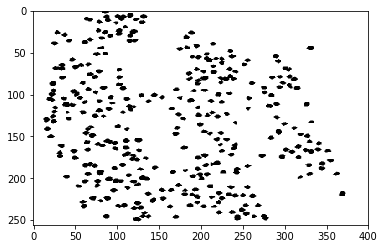

Max value: 255


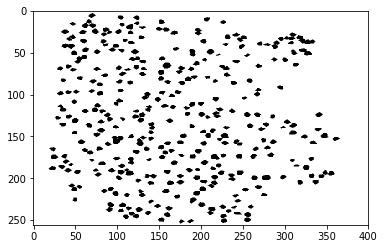

Max value: 1.0


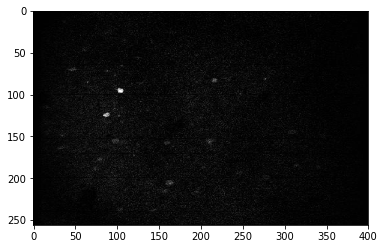

Max value: 0.9294117647058824


In [494]:
vect = cv2.VideoCapture("Databinary/substack500_7fps_00.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(400,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()
print('Max value: ' + str(lab_frame.max()))

plt.imshow(y[0][0].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(y[0][0].max()))

plt.imshow(X[0][1].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(X[0][0].max()))

TRAIN ON MODEL

In [501]:
model_stateful_batchn = load_model(batch_size,true_frag_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (5, 25, 256, 400, 1)      0         
_________________________________________________________________
time_distributed_165 (TimeDi (5, 25, 256, 400, 2)      20        
_________________________________________________________________
time_distributed_166 (TimeDi (5, 25, 128, 200, 2)      0         
_________________________________________________________________
batch_normalization_83 (Batc (5, 25, 128, 200, 2)      8         
_________________________________________________________________
conv_lst_m2d_42 (ConvLSTM2D) (5, 25, 128, 200, 14)     8120      
_________________________________________________________________
batch_normalization_84 (Batc (5, 25, 128, 200, 14)     56        
_________________________________________________________________
time_distributed_167 (TimeDi (5, 25, 128, 200, 2)      254       
__________

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/ipykernel_launcher.py:52: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [502]:
gener = Batch_size_n_Generator(batch_size,frag_len,steps)
valid_generator = Batch_size_n_Generator(batch_size, frag_len, steps, valid = True)
validator_n = Validate_and_Metrics()
model_stateful_batchn_trained, epoch_execution_time = train_model(model_stateful_batchn, reps_for_samples, no_frags, gener,valid_generator,epochs, true_frag_len,validator_n )

Training for 5 epochs
Number of training reps per epoch 450
['04', '02', '00', '06', '08']
# Iteration 0   loss  1.0172890424728394
# Iteration 50   loss  0.7180150747299194
# Iteration 100   loss  0.6837515830993652
# Iteration 150   loss  0.6661084294319153
# Iteration 200   loss  0.6631891131401062
225
['07', '00', '08', '08', '07']
# Iteration 250   loss  0.646867573261261
# Iteration 300   loss  0.6394096612930298
# Iteration 350   loss  0.6337345242500305
# Iteration 400   loss  0.6210266947746277
225
# Epoch 1   loss  0.6149207353591919
Done training
Traing loss 0.6149207353591919
Validating
225
Number of training reps per epoch 450
['06', '06', '09', '03', '06']
# Iteration 0   loss  0.6253096461296082
# Iteration 50   loss  0.6082185506820679
# Iteration 100   loss  0.5936375260353088
# Iteration 150   loss  0.5901089906692505
# Iteration 200   loss  0.5759488940238953
225
['04', '09', '08', '01', '06']
# Iteration 250   loss  0.5690408945083618
# Iteration 300   loss  0.56269

In [506]:
minibatch_metrics = validator_n.get_metrics()

In [507]:
minibatch_execution_time = epoch_execution_time

In [505]:
save_model(model_stateful_batchn_trained, 'minibatch_5e_frag_50_step_2_len500_vid')

PREDICT ON TRAINED MODEL

In [513]:
gener_n = Batch_size_n_Generator(batch_size, frag_len, steps)
# this just tests out one sample. I think it is necessary to reset states on prediction too
# Predict using just a single sample loaded from file
stateful_preds_n = validator_n.batch_prediction(gener_n)

['06', '05', '06', '04', '07']
225


In [517]:
len(stateful_preds_n), stateful_preds_n[0].shape

(225, (5, 25, 256, 400, 1))

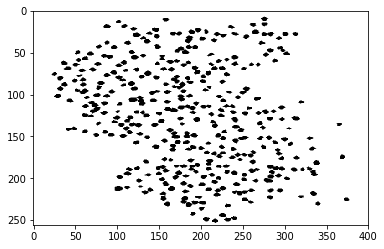

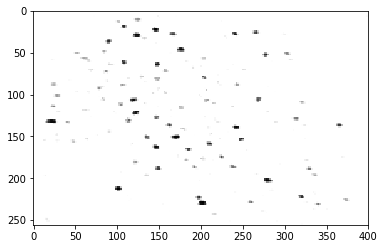

In [555]:
# Second index is the video number, first index the fragment 
predictedn = stateful_preds_n[10][4].reshape(true_frag_len,256,400)

vect = cv2.VideoCapture("Databinary/substack500_7fps_07.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(400,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()

#predicted result
# this index is the frame in the fragment
plt.imshow(predictedn[1], cmap = 'gray')
plt.show()

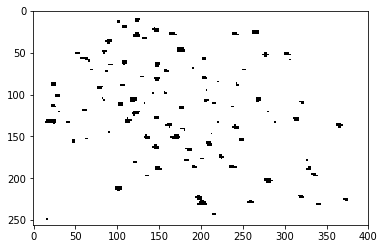

In [556]:
from skimage.filters import try_all_threshold

#fig, ax = try_all_threshold(predicted[1], figsize=(10, 8), verbose=False)
thresh = threshold_yen(predicted[1])
plt.imshow(predictedn[1]>thresh,  cmap = 'gray')
plt.show(thresh, )

# Evaluation Analysis

Average Run time per epoch

In [508]:
print ("Stochastic: " + str(np.mean(stochastic_execution_time)) + " +/- " + str(np.std(stochastic_execution_time))) 
print ("Mini-batch: " + str(np.mean(minibatch_execution_time)) + " +/- " + str(np.std(minibatch_execution_time))) 

Stochastic: 7654.24012556076 +/- 92.88140418064039
Mini-batch: 9797.574591588975 +/- 242.49565856877726


 Plot of F1 scores and Precision and Recall

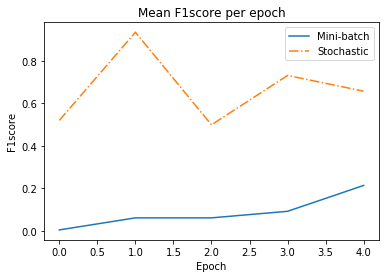

In [509]:
fig = plt.figure()
ax = plt.axes()
ax.set(xlabel='Epoch', ylabel='F1score',
       title='Mean F1score per epoch')
plt.plot(minibatch_metrics['f1scores'], label='Mini-batch')
plt.plot(stocahstic_metrics['f1scores'],linestyle='dashdot',label='Stochastic')
plt.legend();

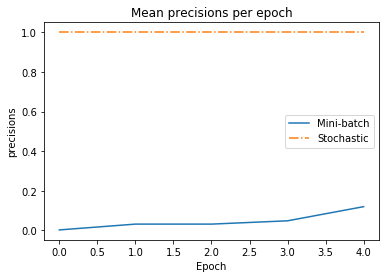

In [510]:
fig = plt.figure()
ax = plt.axes()
ax.set(xlabel='Epoch', ylabel='precisions',
       title='Mean precisions per epoch')
plt.plot(minibatch_metrics['precisions'], label='Mini-batch')
plt.plot(stocahstic_metrics['precisions'],linestyle='dashdot',label='Stochastic')
plt.legend();

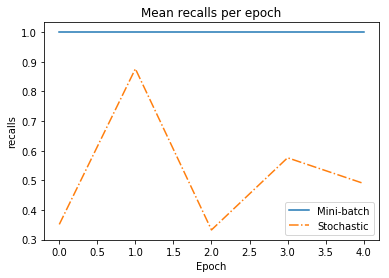

In [511]:
fig = plt.figure()
ax = plt.axes()
ax.set(xlabel='Epoch', ylabel='recalls',
       title='Mean recalls per epoch')
plt.plot(minibatch_metrics['recalls'], label='Mini-batch')
plt.plot(stocahstic_metrics['recalls'],linestyle='dashdot',label='Stochastic')
plt.legend();

In [514]:
minibatch_metrics,stocahstic_metrics

({'f1scores': [0.005039475894506972,
   0.061694140688754694,
   0.061694140688754694,
   0.09251525859299711,
   0.21413533834586465],
  'precisions': [0.002526103065005052,
   0.031828898619063656,
   0.031828898619063656,
   0.048501178848097,
   0.11990569215223981],
  'recalls': [1.0, 1.0, 1.0, 1.0, 1.0]},
 {'f1scores': [0.5198284163529721,
   0.934235368156073,
   0.4991174245608136,
   0.7310557094490612,
   0.6571491810535635],
  'precisions': [1.0, 1.0, 1.0, 1.0, 1.0],
  'recalls': [0.35119470073338066,
   0.8765869501033363,
   0.33254928315412186,
   0.5761133210439507,
   0.4893687160046151]})

Mean F1 score, precision and recall on test set

In [466]:
def save_model(model,name):
    # Creates a HDF5 file 'my_model.h5'
    model.save(name + '.h5')

In [ ]:
from keras.models import load_model
model = load_model('my_model.h5')